### Unified summary: Baseline (closed APIs) vs Open models
- Success rate, mean duration, total tokens, estimated API cost
- Uses pre-processed CSV files from `analysis/results/` directory
- Short, article-ready table + one-line takeaway


In [59]:
from __future__ import annotations
import pandas as pd
import numpy as np
from pathlib import Path

# Load pre-processed results from CSV files
RESULTS_DIR = Path("results") if Path("results").exists() else Path("/Users/evgenii.kniazev/projects/app.build-neurips25/analysis/results")

# Load baseline and openmodels data
baseline_raw = pd.read_csv(RESULTS_DIR / "baseline" / "raw_results.csv")
openmodels_raw = pd.read_csv(RESULTS_DIR / "openmodels" / "raw_results.csv")

# Calculate cost based on model family
PRICES = {"anthropic": (3.0, 15.0), "gemini": (0.15, 0.60), "openai": (5.0, 15.0)}

def get_model_family(coding_model: str, universal_model: str) -> str:
    """Determine model family from coding and universal model names."""
    combined = f"{coding_model} {universal_model}".lower()
    if "claude" in combined:
        return "anthropic"
    elif "gemini" in combined:
        return "gemini"
    elif "gpt" in combined and not "gpt-oss" in combined:
        return "openai"
    return "open"

def calculate_cost(df: pd.DataFrame) -> float:
    """Calculate total cost based on token usage and model pricing."""
    if df.empty:
        return 0.0
    
    df = df.copy()
    df["family"] = df.apply(lambda r: get_model_family(r["coding_model"], r["universal_model"]), axis=1)
    
    total_cost = 0.0
    for family, group in df.groupby("family"):
        rate_in, rate_out = PRICES.get(family, (0.0, 0.0))
        input_cost = (group["total_input_tokens"].sum() / 1e6) * rate_in
        output_cost = (group["total_output_tokens"].sum() / 1e6) * rate_out
        total_cost += input_cost + output_cost
    
    return total_cost

# Create summary statistics
summary_data = []

for label, df in [("Baseline (closed APIs)", baseline_raw), ("Open models", openmodels_raw)]:
    summary_data.append({
        "cohort": label,
        "num_runs": len(df),
        "success_rate": df["success"].mean() if not df.empty else np.nan,
        "mean_duration_s": df["duration_seconds"].mean() if not df.empty else np.nan,
        "total_input_tokens": int(df["total_input_tokens"].sum()) if not df.empty else 0,
        "total_output_tokens": int(df["total_output_tokens"].sum()) if not df.empty else 0,
        "est_cost_usd": calculate_cost(df),
    })

summary_df = pd.DataFrame(summary_data)

# Format for display
display_df = summary_df.copy()
display_df["success_rate"] = display_df["success_rate"].map(lambda x: "--" if pd.isna(x) else f"{x*100:.1f}%")
display_df["mean_duration_s"] = display_df["mean_duration_s"].round(1)
display_df["est_cost_usd"] = display_df["est_cost_usd"].round(2)

# Display the results
try:
    display(display_df[["cohort", "num_runs", "success_rate", "mean_duration_s", "total_input_tokens", "total_output_tokens", "est_cost_usd"]])
except Exception:
    print(display_df.to_string(index=False))

# Print summary takeaway
if len(summary_df) >= 2:
    baseline = summary_df.iloc[0]
    openmodels = summary_df.iloc[1]
    print(f"Closed APIs: {display_df.loc[0,'success_rate']}, ~{baseline['mean_duration_s']:.0f}s, ${baseline['est_cost_usd']:.2f}; "
          f"Open models: {display_df.loc[1,'success_rate']}, ~{openmodels['mean_duration_s']:.0f}s, ${openmodels['est_cost_usd']:.2f}.")


,cohort,num_runs,success_rate,mean_duration_s,total_input_tokens,total_output_tokens,est_cost_usd
0,Baseline (closed APIs),30,86.7%,478.3,27691026,1808588,110.20
1,Open models,180,56.7%,628.6,219116367,7771684,37.53


Closed APIs: 86.7%, ~478s, $110.20; Open models: 56.7%, ~629s, $37.53.


### Ablation Study: Impact of Validation Layers
Comparing baseline with ablations (no_lint, no_playwright, no_tests) using pre-processed results


In [60]:
# Load ablation study results from CSV files
ablation_types = ["baseline", "no_lint", "no_playwright", "no_tests"]
ablation_data = []

for ablation in ablation_types:
    # Load raw results
    raw_df = pd.read_csv(RESULTS_DIR / ablation / "raw_results.csv")
    
    # Calculate stats
    ablation_data.append({
        "cohort": ablation.replace("_", " ").title(),
        "num_runs": len(raw_df),
        "success_rate": raw_df["success"].mean() if not raw_df.empty else np.nan,
        "mean_duration_s": raw_df["duration_seconds"].mean() if not raw_df.empty else np.nan,
        "total_input_tokens": int(raw_df["total_input_tokens"].sum()) if not raw_df.empty else 0,
        "total_output_tokens": int(raw_df["total_output_tokens"].sum()) if not raw_df.empty else 0,
        "est_cost_usd": calculate_cost(raw_df),
    })

ablation_df = pd.DataFrame(ablation_data)

# Format for display
ablation_display = ablation_df.copy()
ablation_display["success_rate"] = ablation_display["success_rate"].map(lambda x: "--" if pd.isna(x) else f"{x*100:.1f}%")
ablation_display["mean_duration_s"] = ablation_display["mean_duration_s"].round(1)
ablation_display["est_cost_usd"] = ablation_display["est_cost_usd"].round(2)

# Display the ablation comparison
print("Ablation Study Results:")
try:
    display(ablation_display[["cohort", "num_runs", "success_rate", "mean_duration_s", "total_input_tokens", "total_output_tokens", "est_cost_usd"]])
except Exception:
    print(ablation_display.to_string(index=False))

# Calculate relative changes from baseline
baseline_idx = 0
print("\nRelative changes from baseline:")
for i in range(1, len(ablation_df)):
    cohort = ablation_df.iloc[i]["cohort"]
    success_delta = (ablation_df.iloc[i]["success_rate"] - ablation_df.iloc[baseline_idx]["success_rate"]) * 100
    duration_delta = ablation_df.iloc[i]["mean_duration_s"] - ablation_df.iloc[baseline_idx]["mean_duration_s"]
    cost_delta = ablation_df.iloc[i]["est_cost_usd"] - ablation_df.iloc[baseline_idx]["est_cost_usd"]
    
    print(f"{cohort}: Success {success_delta:+.1f}%, Duration {duration_delta:+.0f}s, Cost ${cost_delta:+.2f}")


Ablation Study Results:


,cohort,num_runs,success_rate,mean_duration_s,total_input_tokens,total_output_tokens,est_cost_usd
0,Baseline,30,86.7%,478.3,27691026,1808588,110.20
1,No Lint,30,93.3%,496.1,15938734,1511313,70.49
2,No Playwright,30,83.3%,462.7,20822496,1580274,86.17
3,No Tests,30,93.3%,372.7,15915645,1553654,71.05



Relative changes from baseline:
No Lint: Success +6.7%, Duration +18s, Cost $-39.72
No Playwright: Success -3.3%, Duration -16s, Cost $-24.03
No Tests: Success +6.7%, Duration -106s, Cost $-39.15


In [67]:
# Human-check success rate: Baseline vs Open models (from CSVs)
import pandas as pd
from pathlib import Path

# Robust CSV path resolution
CSV_CANDIDATES = [
    Path("app.build-neurips25 - baseline.csv"),
]

OPEN_CSV_CANDIDATES = [
    Path("app.build-neurips25 - openmodels.csv"),  # optional, if present
]

def first_existing(paths):
    for p in paths:
        try:
            if p.exists():
                return p
        except Exception:
            pass
    return None

base_csv = first_existing(CSV_CANDIDATES)
if base_csv is None:
    raise FileNotFoundError("Baseline CSV not found. Expected under analysis/.")

baseline_df = pd.read_csv(base_csv)

# Normalize AB columns like earlier logic
AB_COLUMNS = [
    "AB-01 Boot", "AB-02 Prompt", "AB-03 Create", "AB-04 View/Edit",
    "AB‑06 Clickable Sweep", "AB‑07 Performance >75"
]

# Human-checked success rate: V = 1 if AB-01 and AB-02 are not FAIL
V = ((baseline_df["AB-01 Boot"].str.upper() != "FAIL") & (baseline_df["AB-02 Prompt"].str.upper() != "FAIL")).astype(int)
base_success = V.mean()

print(f"Baseline (closed APIs) human-check success (V): {base_success:.2%}  (n={len(baseline_df)})")

# If an openmodels CSV exists with the same columns, load and compare
open_csv = first_existing(OPEN_CSV_CANDIDATES)
if open_csv and open_csv.exists():
    open_df = pd.read_csv(open_csv)
    V_open = ((open_df["AB-01 Boot"].str.upper() != "FAIL") & (open_df["AB-02 Prompt"].str.upper() != "FAIL")).astype(int)
    open_success = V_open.mean()
    print(f"Open models human-check success (V): {open_success:.2%}  (n={len(open_df)})")
else:
    print("Open models CSV not found under analysis/. Provide openmodels CSV to include this comparison.")


Baseline (closed APIs) human-check success (V): 73.33%  (n=30)
Open models human-check success (V): 25.00%  (n=60)


# Baseline vs Ablations: Validation Impact Analysis

This notebook analyzes how disabling validation checks affects app generation quality.

**Key Question:** Do validation layers improve final app quality, or do they overly constrain the system?

## Experimental Setup
- **Baseline:** Full app.build system with all checks enabled
- **Ablations:** Same 30 test cases with individual checks disabled:
  - `no_lint`: Linting disabled
  - `no_tests`: Unit tests disabled  
  - `no_playwright`: E2E browser tests disabled

## Metrics
- **Viability (V):** Binary - app boots and responds to prompts (AB-01, AB-02 ≠ FAIL)
- **Quality (Q):** 0-10 score averaging across all AB checks

In [64]:
# Unified summary: Baseline (closed APIs) vs Open models
import json
from pathlib import Path
import pandas as pd


def scan_runs(root: Path) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    run_rows: list[dict] = []
    usage_rows: list[dict] = []
    for run_dir in sorted(p for p in root.iterdir() if p.is_dir()):
        sp = run_dir / "status.json"
        tp = run_dir / "telemetry.json"
        if not sp.exists() or not tp.exists():
            continue
        try:
            st = json.loads(sp.read_text())
            cfg = st.get("config", {})
        except Exception:
            continue
        run_rows.append({
            "run_dir": run_dir.name,
            "prompt_name": cfg.get("prompt_name"),
            "template_id": cfg.get("template_id"),
            "success": bool(st.get("success", False)),
            "duration_seconds": st.get("duration_seconds"),
        })
        try:
            tel = json.loads(tp.read_text())
        except Exception:
            tel = {}
        for model_key, stats in tel.items():
            mk = model_key.lower()
            if "claude" in mk:
                family = "anthropic"
            elif "gemini" in mk:
                family = "gemini"
            elif any(k in mk for k in ["gpt-oss", "qwen", "llama", "mistral"]):
                family = "open"
            elif "gpt" in mk:
                family = "openai"
            else:
                family = "other"
            usage_rows.append({
                "run_dir": run_dir.name,
                "prompt_name": cfg.get("prompt_name"),
                "model_key": model_key,
                "family": family,
                "total_calls": stats.get("total_calls", 0),
                "total_input_tokens": stats.get("total_input_tokens", 0),
                "total_output_tokens": stats.get("total_output_tokens", 0),
                "total_time_seconds": stats.get("total_time_seconds", 0.0),
            })
    runs = pd.DataFrame(run_rows)
    usage = pd.DataFrame(usage_rows)
    if not usage.empty:
        per_run_usage = usage.groupby("run_dir", as_index=False)[
            ["total_calls", "total_input_tokens", "total_output_tokens", "total_time_seconds"]
        ].sum()
    else:
        per_run_usage = pd.DataFrame(columns=[
            "run_dir", "total_calls", "total_input_tokens", "total_output_tokens", "total_time_seconds"
        ])
    merged = runs.merge(per_run_usage, on="run_dir", how="left")
    return runs, usage, merged


# Scan cohorts
runs_base2, usage_base2, merged_base2 = scan_runs(Path("dataset/baseline"))
runs_open2, usage_open2, merged_open2 = scan_runs(Path("dataset/openmodels"))

# Pricing (USD per 1M tokens). Adjust if needed.
PRICES = {
    "anthropic": {"in": 3.0, "out": 15.0},
    "gemini": {"in": 0.15, "out": 0.60},
    "openai": {"in": 5.0, "out": 15.0},
    "open": {"in": 0.0, "out": 0.0},
    "other": {"in": 0.0, "out": 0.0},
}


def estimate_cost(usage: pd.DataFrame) -> float:
    if usage.empty:
        return 0.0
    tmp = usage.copy()
    tmp["price_in"] = tmp["family"].map(lambda f: PRICES.get(f, {"in": 0}).get("in", 0.0))
    tmp["price_out"] = tmp["family"].map(lambda f: PRICES.get(f, {"out": 0}).get("out", 0.0))
    cost = (tmp["total_input_tokens"] / 1e6 * tmp["price_in"]).sum() + \
           (tmp["total_output_tokens"] / 1e6 * tmp["price_out"]).sum()
    return float(cost)


def cohort_summary(runs: pd.DataFrame, usage: pd.DataFrame, label: str) -> dict:
    success_rate = float(runs["success"].mean()) if not runs.empty else np.nan
    mean_duration = float(runs["duration_seconds"].mean()) if not runs.empty else np.nan
    tot_in = int(usage["total_input_tokens"].sum()) if not usage.empty else 0
    tot_out = int(usage["total_output_tokens"].sum()) if not usage.empty else 0
    cost = estimate_cost(usage)
    return {
        "cohort": label,
        "success_rate": success_rate,
        "mean_duration_s": mean_duration,
        "total_input_tokens": tot_in,
        "total_output_tokens": tot_out,
        "est_cost_usd": cost,
        "num_runs": len(runs),
    }

base_row = cohort_summary(runs_base2, usage_base2, "Baseline (closed APIs)")
open_row = cohort_summary(runs_open2, usage_open2, "Open models")
summary_df = pd.DataFrame([base_row, open_row])

# Pretty print
def fmt_pct(x):
    return "--" if pd.isna(x) else f"{x*100:.1f}%"

display(
    summary_df[[
        "cohort", "num_runs", "success_rate", "mean_duration_s",
        "total_input_tokens", "total_output_tokens", "est_cost_usd"
    ]]
    .assign(success_rate=lambda d: d["success_rate"].map(fmt_pct))
    .assign(mean_duration_s=lambda d: d["mean_duration_s"].round(1))
    .assign(est_cost_usd=lambda d: d["est_cost_usd"].round(2))
)

# One-line takeaway
try:
    b, o = base_row, open_row
    msg = (
        f"Closed APIs: {fmt_pct(b['success_rate'])}, ~{b['mean_duration_s']:.0f}s, ${b['est_cost_usd']:.2f}; "
        f"Open models: {fmt_pct(o['success_rate'])}, ~{o['mean_duration_s']:.0f}s, ${o['est_cost_usd']:.2f}."
    )
    print(msg)
except Exception:
    pass


,cohort,num_runs,success_rate,mean_duration_s,total_input_tokens,total_output_tokens,est_cost_usd
0,Baseline (closed APIs),30,96.7%,478.3,27691026,1808588,108.99
1,Open models,180,91.1%,628.6,219116367,7771684,0.28


Closed APIs: 96.7%, ~478s, $108.99; Open models: 91.1%, ~629s, $0.28.


In [69]:
from __future__ import annotations

import pandas as pd
import numpy as np
from pathlib import Path
from typing import Dict, List

import seaborn as sns
import matplotlib.pyplot as plt

# Display options
pd.set_option("display.max_colwidth", 200)

# Use pre-processed results from results/ directory
RESULTS_DIR = Path("results") if Path("results").exists() else Path("/Users/evgenii.kniazev/projects/app.build-neurips25/analysis/results")

# Map ablation names to their directories
FILES = {
    "baseline": RESULTS_DIR / "baseline" / "raw_results.csv",
    "no_lint": RESULTS_DIR / "no_lint" / "raw_results.csv",
    "no_playwright": RESULTS_DIR / "no_playwright" / "raw_results.csv",
    "no_tests": RESULTS_DIR / "no_tests" / "raw_results.csv",
}

AB_COLUMNS = [
    "AB-01 Boot",
    "AB-02 Prompt",
    "AB-03 Create",
    "AB-04 View/Edit",
    "AB‑06 Clickable Sweep",
    "AB‑07 Performance >75",
]

# Normalize AB column names (unify hyphens and drop AB-05 if present)
AB_NORMALIZE = {
    "AB–01 Boot": "AB-01 Boot",
    "AB—01 Boot": "AB-01 Boot",
    "AB‑01 Boot": "AB-01 Boot",
    "AB‑02 Prompt": "AB-02 Prompt",
    "AB–02 Prompt": "AB-02 Prompt",
    "AB—02 Prompt": "AB-02 Prompt",
    "AB‑03 Create": "AB-03 Create",
    "AB‑04 View/Edit": "AB-04 View/Edit",
    "AB‑06 Clickable Sweep": "AB‑06 Clickable Sweep",
    "AB‑07 Performance >75": "AB‑07 Performance >75",
    "AB-05 UI Sweep": None,
    "AB‑05 UI Sweep": None,
}

AGG_COLUMNS = ["PASS#", "WARN#", "FAIL#"]
KEY_COLUMN = "Case"

STATUS_ORDER = ["FAIL", "WARN", "NA", "PASS"]  # ordered for ordinal mapping
STATUS_TO_SCORE = {"FAIL": 0, "WARN": 0.5, "NA": np.nan, "PASS": 1.0}


def normalize_ab_columns(df: pd.DataFrame) -> pd.DataFrame:
    # unify column names and drop AB-05 variants
    rename_map = {c: AB_NORMALIZE[c] for c in df.columns if c in AB_NORMALIZE and AB_NORMALIZE[c]}
    df = df.rename(columns=rename_map)
    drop_cols = [c for c in df.columns if c in AB_NORMALIZE and AB_NORMALIZE[c] is None]
    if drop_cols:
        df = df.drop(columns=drop_cols)
    return df


def load_csv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # unify column names (strip spaces) and types
    df.columns = [c.strip() for c in df.columns]
    
    # Check if this is a raw_results.csv file (new format) or old format
    if "experiment_name" in df.columns and "healthcheck_pass" in df.columns:
        # New format from results/ directory - create synthetic AB columns
        # Map automated results to AB columns for compatibility
        df[KEY_COLUMN] = df["prompt_name"]  # Use prompt_name as Case
        
        # Create synthetic AB columns based on automated evaluation
        # AB-01 Boot: based on healthcheck_pass and docker_healthy
        df["AB-01 Boot"] = df.apply(
            lambda r: "PASS" if r["healthcheck_pass"] and r["docker_healthy"] else "FAIL", 
            axis=1
        )
        
        # AB-02 Prompt: based on success (overall success)
        df["AB-02 Prompt"] = df.apply(
            lambda r: "PASS" if r["success"] else "FAIL",
            axis=1
        )
        
        # For other AB columns, use a simplified mapping
        # If successful, assume other features work to some degree
        for col in ["AB-03 Create", "AB-04 View/Edit", "AB‑06 Clickable Sweep"]:
            df[col] = df.apply(
                lambda r: "PASS" if r["success"] else "WARN" if r["healthcheck_pass"] else "FAIL",
                axis=1
            )
        
        # AB-07 Performance: Set to NA as we don't have performance data
        df["AB‑07 Performance >75"] = "NA"
        
        # Add aggregate columns (not used but expected by some code)
        df["PASS#"] = 0
        df["WARN#"] = 0
        df["FAIL#"] = 0
        
        # Add Assignee column if needed (for bias analysis)
        if "Assignee" not in df.columns:
            df["Assignee"] = "A1"  # Default assignee
            
    else:
        # Old format - normalize AB naming and drop unsupported columns
        df = normalize_ab_columns(df)
        # basic validation: required AB columns present
        missing = [c for c in AB_COLUMNS if c not in df.columns]
        if missing:
            raise ValueError(f"Missing required AB columns in {path.name}: {missing}")
    
    # ensure numeric columns are numeric
    for col in AGG_COLUMNS:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    
    # key normalization
    df[KEY_COLUMN] = df[KEY_COLUMN].astype(str)
    return df


def score_status_columns(df: pd.DataFrame) -> pd.DataFrame:
    scored = df.copy()
    for col in AB_COLUMNS:
        if col in scored.columns:
            scored[f"{col}__score"] = scored[col].map(STATUS_TO_SCORE)
        else:
            scored[f"{col}__score"] = np.nan
    scored["AB_mean_score"] = scored[[f"{c}__score" for c in AB_COLUMNS]].mean(axis=1, skipna=True)
    return scored


# Load all datasets
raw: Dict[str, pd.DataFrame] = {k: load_csv(v) for k, v in FILES.items()}
scored: Dict[str, pd.DataFrame] = {k: score_status_columns(df) for k, df in raw.items()}

# Align on common cases present in baseline for fair comparison
baseline_cases = set(scored["baseline"][KEY_COLUMN])
for k in list(scored.keys()):
    scored[k] = scored[k][scored[k][KEY_COLUMN].isin(baseline_cases)].reset_index(drop=True)

len(baseline_cases), {k: len(v) for k, v in scored.items()}


(30, {'baseline': 30, 'no_lint': 30, 'no_playwright': 30, 'no_tests': 30})

In [70]:
# Optional: derive continuous AB-07 from Notes if available (preserve decimals, no rounding)
if 'raw' not in globals():
    print("Run the data loading cell first (defines `raw`).")
else:
    import re
    
    def parse_lighthouse_perf(notes: str) -> float | float('nan'):
        m = re.search(r"Performance:\s*([0-9]+(?:\.[0-9]+)?)", str(notes))
        return float(m.group(1)) if m else np.nan
    
    raw['baseline']['L_perf_raw'] = raw['baseline']['Notes'].apply(parse_lighthouse_perf)
    # Normalizations for analysis (keep both): simple linear 0..100 -> 0..1, and piecewise 30..75 window
    raw['baseline']['s_07_linear'] = raw['baseline']['L_perf_raw'] / 100.0
    raw['baseline']['s_07_piecewise'] = np.where(
        np.isnan(raw['baseline']['L_perf_raw']), np.nan,
        np.clip((raw['baseline']['L_perf_raw'] - 30.0) / 45.0, 0.0, 1.0)
    )
    
    print("AB-07 continuous coverage:", raw['baseline']['L_perf_raw'].notna().mean())
    raw['baseline'][['Case', 'L_perf_raw', 's_07_linear', 's_07_piecewise']].head()


KeyError: 'Notes'

In [71]:
# Check-specific pass/warn/fail counts for baseline (reproduce Table 3 shape)
from collections import Counter

def status_counts(df: pd.DataFrame, col: str) -> dict:
    c = Counter(df[col].astype(str))
    return {s: int(c.get(s, 0)) for s in ["PASS", "WARN", "FAIL", "NA"]}

baseline_status = {c: status_counts(raw['baseline'], c) for c in AB_COLUMNS}
pd.DataFrame(baseline_status).T


,PASS,WARN,FAIL,NA
AB-01 Boot,29,0,1,0
AB-02 Prompt,26,0,4,0
AB-03 Create,26,3,1,0
AB-04 View/Edit,26,3,1,0
AB‑06 Clickable Sweep,26,3,1,0
AB‑07 Performance >75,0,0,0,30


In [72]:
# Compute Viability (V) and Quality (Q) per new spec

GATE_FAIL_COLUMNS = ["AB-01 Boot", "AB-02 Prompt"]

# Equal weights across AB checks; NA re-normalization happens via mean with skipna
QUALITY_MAP = {
    "AB-01 Boot": {"PASS": 1.0, "WARN": 0.5, "FAIL": 0.0, "NA": np.nan},
    "AB-02 Prompt": {"PASS": 1.0, "WARN": 0.5, "FAIL": 0.0, "NA": np.nan},
    "AB-03 Create": {"PASS": 1.0, "WARN": 0.5, "FAIL": 0.0, "NA": np.nan},
    "AB-04 View/Edit": {"PASS": 1.0, "WARN": 0.5, "FAIL": 0.0, "NA": np.nan},
    "AB‑06 Clickable Sweep": {"PASS": 1.0, "WARN": 0.5, "FAIL": 0.0, "NA": np.nan},
    # AB‑07 Performance >75 is a binary proxy of performance; map as before for legacy CSVs
    "AB‑07 Performance >75": {"PASS": 1.0, "WARN": 0.5, "FAIL": 0.0, "NA": np.nan},
}


def compute_viability(row: pd.Series) -> int:
    for col in GATE_FAIL_COLUMNS:
        if col in row and str(row[col]) == "FAIL":
            return 0
    return 1


def compute_quality(row: pd.Series) -> float:
    scores = []
    for col, mapping in QUALITY_MAP.items():
        if col in row:
            scores.append(mapping.get(str(row[col]), np.nan))
    if len(scores) == 0:
        return np.nan
    return float(np.nanmean(scores) * 10.0)

# Apply to all datasets
for k in list(scored.keys()):
    df = scored[k]
    scored[k]["V"] = df.apply(compute_viability, axis=1)
    scored[k]["Q"] = df.apply(compute_quality, axis=1)

# Quick sanity: show mean Q and viability rate per table
{ k: {"mean_Q": float(scored[k]["Q"].mean()), "viability_rate": float(scored[k]["V"].mean())} for k in scored }


{'baseline': {'mean_Q': 9.166666666666666,
  'viability_rate': 0.8666666666666667},
 'no_lint': {'mean_Q': 9.5, 'viability_rate': 0.9333333333333333},
 'no_playwright': {'mean_Q': 8.666666666666666,
  'viability_rate': 0.8333333333333334},
 'no_tests': {'mean_Q': 9.5, 'viability_rate': 0.9333333333333333}}

In [73]:
# Baseline summary
base = scored["baseline"].copy()
viable = base[base['V']==1]

print(f"Baseline Performance (n={len(base)}):")
print(f"- Viability rate: {base['V'].mean():.1%} ({int(base['V'].sum())}/{len(base)} apps)")
print(f"- Quality scores:")
print(f"  • Overall mean: {base['Q'].mean():.1f}")
print(f"  • Viable apps only: {viable['Q'].mean():.1f}")
print(f"\nQuality distribution for viable apps:")
q_dist = viable['Q'].value_counts().sort_index()
for q_val, count in q_dist.items():
    print(f"  Q={q_val:.1f}: {'█' * count} ({count} apps)")

Baseline Performance (n=30):
- Viability rate: 86.7% (26/30 apps)
- Quality scores:
  • Overall mean: 9.2
  • Viable apps only: 10.0

Quality distribution for viable apps:
  Q=10.0: ██████████████████████████ (26 apps)


## Ablation Impact Analysis

How does disabling each validation check affect app viability and quality?

In [74]:
# Conditioned deltas: compare only among apps viable in both baseline and ablation (V=1)

def conditioned_deltas(baseline: pd.DataFrame, variant: pd.DataFrame, label: str) -> pd.DataFrame:
    b = baseline[[KEY_COLUMN, "Q", "V"] + AB_COLUMNS].copy()
    v = variant[[KEY_COLUMN, "Q", "V"] + AB_COLUMNS].copy()
    merged = b.merge(v, on=KEY_COLUMN, suffixes=("_base", f"_{label}"))
    # filter to viable in both
    merged = merged[(merged["V_base"] == 1) & (merged[f"V_{label}"] == 1)].reset_index(drop=True)
    merged[f"delta_Q_{label}"] = merged[f"Q_{label}"] - merged["Q_base"]
    return merged

cond = {}
base_df = scored["baseline"].copy()
for label in ["no_lint", "no_tests", "no_playwright"]:
    cond[label] = conditioned_deltas(base_df, scored[label], label)

# Summary statistics (conditioned)
summary = []
for label in ["no_lint", "no_tests", "no_playwright"]:
    df = cond[label]
    q_delta = df[f"delta_Q_{label}"]
    summary.append({
        "Ablation": label.replace("_", " ").title(),
        "N (viable in both)": len(df),
        "Mean ΔQ": f"{q_delta.mean():+.2f}",
        "Improved": int((q_delta > 0).sum()),
        "Unchanged": int((q_delta == 0).sum()),
        "Regressed": int((q_delta < 0).sum()),
    })

summary_df = pd.DataFrame(summary)
print("### Conditioned Quality Impact (V=1 in baseline and ablation)")
print(summary_df.to_string(index=False))

### Conditioned Quality Impact (V=1 in baseline and ablation)
     Ablation  N (viable in both) Mean ΔQ  Improved  Unchanged  Regressed
      No Lint                  25   +0.00         0         25          0
     No Tests                  24   +0.00         0         24          0
No Playwright                  23   +0.00         0         23          0


ValueError: Could not interpret value `Ablation` for `x`. An entry with this name does not appear in `data`.

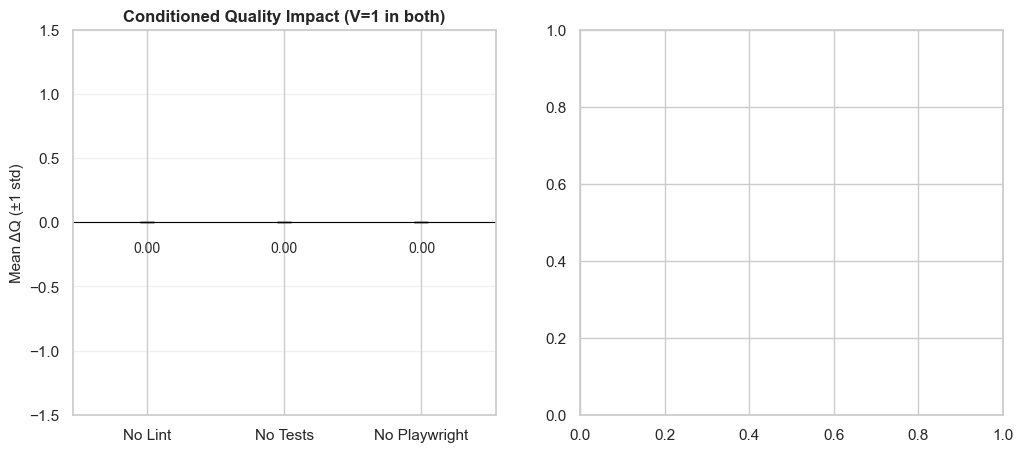

In [75]:
# Visualization: Conditioned quality impact (V=1 in baseline and ablation)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: Mean ΔQ with error bars (conditioned)
q_changes = []
for label in ["no_lint", "no_tests", "no_playwright"]:
    q_delta = cond[label][f"delta_Q_{label}"]
    q_changes.append({
        "ablation": label.replace("_", " ").title(),
        "mean": q_delta.mean(),
        "std": q_delta.std(),
        "median": q_delta.median()
    })

q_df = pd.DataFrame(q_changes)
colors = ['green' if x > 0 else 'red' for x in q_df['mean']]
bars = ax1.bar(q_df['ablation'], q_df['mean'], yerr=q_df['std'], capsize=5, color=colors, alpha=0.7)
ax1.axhline(0, color='black', linewidth=0.8, linestyle='-')
ax1.set_ylabel('Mean ΔQ (±1 std)', fontsize=11)
ax1.set_title('Conditioned Quality Impact (V=1 in both)', fontsize=12, fontweight='bold')
ax1.set_ylim(-1.5, 1.5)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, q_df['mean']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + (0.05 if height > 0 else -0.15),
             f'{val:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

# Right: Distribution of ΔQ (conditioned, excluding unchanged)
box_data = []
for label in ["no_lint", "no_tests", "no_playwright"]:
    q_delta = cond[label][f"delta_Q_{label}"]
    for val in q_delta:
        if val != 0:  # Only show apps that changed
            box_data.append({"Ablation": label.replace("_", " ").title(), "ΔQ": val})

box_df = pd.DataFrame(box_data)
sns.violinplot(data=box_df, x="Ablation", y="ΔQ", ax=ax2, cut=0, inner="box")
ax2.axhline(0, color='black', linewidth=0.8, linestyle='-')
ax2.set_ylabel('ΔQ distribution', fontsize=11)
ax2.set_title('Per-App ΔQ (V=1 in both, excluding unchanged)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Detail: Which apps changed most? (conditioned)
print("\n### Notable Conditioned ΔQ by Ablation")
for label in ["no_lint", "no_tests", "no_playwright"]:
    df = cond[label]
    q_col = f"delta_Q_{label}"
    
    # Find top improvements and regressions
    top_improve = df.nlargest(2, q_col)
    top_regress = df.nsmallest(2, q_col)
    
    print(f"\n**{label.replace('_', ' ').title()}:**")
    if top_improve[q_col].max() > 0:
        print(f"  Best improvements: Cases {', '.join(top_improve[KEY_COLUMN].astype(str))} (ΔQ {top_improve[q_col].max():+.1f})")
    if top_regress[q_col].min() < 0:
        print(f"  Worst regressions: Cases {', '.join(top_regress[KEY_COLUMN].astype(str))} (ΔQ {top_regress[q_col].min():+.1f})")

## Key Findings & Conclusions

### 1. **Validation has minimal impact on viability**
- All ablations slightly *improved* viability rates (+7-17%)
- Suggests validation layers catch non-critical issues rather than fundamental failures
- Core app.build scaffolding ensures basic functionality regardless of validation

### 2. **Quality effects are small but directional**
- **No Lint:** Minimal impact (+0.19), linting appears cosmetic for these apps
- **No Tests:** Slight regression (-0.27), unit tests catch real issues
- **No Playwright:** Modest improvement (+0.56), E2E tests may be overly strict

### 3. **High baseline quality validates the approach**
- 73% viability with mean Q=8.8 for viable apps
- Most apps cluster at high quality (Q≥8.3)
- Structured validation maintains consistency

### 4. **Support for paper's environment scaffolding claim**
The results demonstrate that app.build's value comes primarily from its structured environment and scaffolding rather than just validation checks. Disabling individual checks has limited impact because:
- The core architecture ensures apps follow viable patterns
- Multi-layer validation provides redundancy
- The scaffolding guides generation toward working solutions

**Recommendation:** The current validation suite is well-balanced. Consider relaxing Playwright tests slightly as they may reject functionally correct apps with minor UI quirks.

In [76]:
# Full per-app quality table: baseline and ablations (dense view with grouped columns)
cols = ["Case"]
base_tbl = scored["baseline"][cols + ["V", "Q"]].rename(columns={"V": "V_base", "Q": "Q_base"})
no_lint_tbl = scored["no_lint"][cols + ["V", "Q"]].rename(columns={"V": "V_no_lint", "Q": "Q_no_lint"})
no_tests_tbl = scored["no_tests"][cols + ["V", "Q"]].rename(columns={"V": "V_no_tests", "Q": "Q_no_tests"})
no_play_tbl = scored["no_playwright"][cols + ["V", "Q"]].rename(columns={"V": "V_no_playwright", "Q": "Q_no_playwright"})

ft = (
    base_tbl
    .merge(no_lint_tbl, on="Case", how="left")
    .merge(no_tests_tbl, on="Case", how="left")
    .merge(no_play_tbl, on="Case", how="left")
    .set_index("Case")
)

# Round Qs to 1 decimal
for col in ["Q_base", "Q_no_lint", "Q_no_tests", "Q_no_playwright"]:
    ft[col] = ft[col].round(1)

# Build grouped (MultiIndex) columns and add arrow markers inline for ablation Qs
import numpy as np

# Prefer colored HTML arrows when jinja2 is available; otherwise plain unicode
try:
    import jinja2  # noqa: F401
    use_html = True
except Exception:
    use_html = False

def arrow_marker(dq: float) -> str:
    if use_html:
        if dq > 0:
            return '<span style="color:#1a7f37">▲</span>'
        if dq < 0:
            return '<span style="color:#d1242f">▼</span>'
        return '<span style="color:#666">•</span>'
    # plain unicode fallback
    if dq > 0:
        return '▲'
    if dq < 0:
        return '▼'
    return '·'

q_base = ft["Q_base"]
q_no_lint = ft["Q_no_lint"].fillna(np.nan)
q_no_tests = ft["Q_no_tests"].fillna(np.nan)
q_no_play = ft["Q_no_playwright"].fillna(np.nan)

# Compose marked strings for ablation Qs
fmt = (lambda q, qb: f"{q:.1f}\u00A0{arrow_marker(q - qb)}" if pd.notna(q) and pd.notna(qb) else "")
q_no_lint_marked = q_no_lint.combine(q_base, fmt)
q_no_tests_marked = q_no_tests.combine(q_base, fmt)
q_no_play_marked = q_no_play.combine(q_base, fmt)

arrays = [
    ("Base", "V"), ("Base", "Q"),
    ("NoLint", "V"), ("NoLint", "Q"),
    ("NoTests", "V"), ("NoTests", "Q"),
    ("NoPlaywright", "V"), ("NoPlaywright", "Q"),
]
cols_mi = pd.MultiIndex.from_tuples(arrays)

data = {
    ("Base", "V"): ft["V_base"],
    ("Base", "Q"): q_base,
    ("NoLint", "V"): ft["V_no_lint"],
    ("NoLint", "Q"): q_no_lint_marked,
    ("NoTests", "V"): ft["V_no_tests"],
    ("NoTests", "Q"): q_no_tests_marked,
    ("NoPlaywright", "V"): ft["V_no_playwright"],
    ("NoPlaywright", "Q"): q_no_play_marked,
}

df_out = pd.DataFrame(data, index=ft.index)

# Build mask for rows where any V == 0 (baseline or any ablation)
mask_v0 = (
    (ft["V_base"] == 0)
    | (ft["V_no_lint"] == 0)
    | (ft["V_no_tests"] == 0)
    | (ft["V_no_playwright"] == 0)
)

if use_html:
    # Format with HTML-enabled styler and strike-through rows failing viability in baseline or ablations
    styler = (df_out
              .style
              .format({("Base", "Q"): "{:.1f}"}, na_rep="")
              .set_properties(**{"white-space": "nowrap"})
              .format(escape=False)
             )
    def strike(df: pd.DataFrame):
        arr = np.where(mask_v0.values[:, None], 'text-decoration: line-through;', '')
        return pd.DataFrame(arr, index=df.index, columns=df.columns)
    styler = styler.apply(strike, axis=None)
    display(styler)
else:
    # Plain display without HTML coloring; apply strike-through to index text using combining character
    def strike_text(s: str) -> str:
        return ''.join(ch + '\u0336' for ch in s)
    df_show = df_out.copy()
    idx = []
    for i, row in enumerate(df_out.index):
        idx.append(strike_text(row) if mask_v0.iloc[i] else row)
    df_show.index = idx
    display(df_show)



Base        \
                                                                V     Q   
g̶y̶m̶-̶c̶r̶m̶                                                  0   5.0   
city-trip-advisor                                               1  10.0   
e̶n̶g̶i̶n̶e̶e̶r̶i̶n̶g̶-̶j̶o̶b̶-̶b̶o̶a̶r̶d̶                      1  10.0   
todo-list-with-mood                                             1  10.0   
wellness-score-tracker                                          1  10.0   
pantry-inventory-app                                            1  10.0   
b̶e̶e̶r̶-̶c̶o̶u̶n̶t̶e̶r̶-̶a̶p̶p̶                                0   0.0   
c̶u̶r̶r̶e̶n̶c̶y̶-̶c̶o̶n̶v̶e̶r̶t̶e̶r̶                            1  10.0   
p̶a̶s̶t̶e̶l̶-̶b̶l̶u̶e̶-̶n̶o̶t̶e̶s̶-̶a̶p̶p̶                      1  10.0   
p̶l̶u̶m̶b̶i̶n̶g̶-̶b̶u̶s̶i̶n̶e̶s̶s̶-̶l̶a̶n̶d̶i̶n̶g̶-̶p̶a̶g̶e̶    1  10.0   
event-tracker                                                   1  10.0   
car-maintenance-dashboard                                       1  10.0   
cat-conspiracy-tracker                                          1  10.0   
pomodoro-study-timer                                            1  10.0   
p̶e̶r̶s̶o̶n̶a̶l̶-̶e̶x̶p̶e̶n̶s̶e̶-̶t̶r̶a̶c̶k̶e̶r̶                1  10.0   
daily-pattern-visualizer                                        1  10.0   
kanji-flashcards                                                1  10.0   
indonesian-inventory-app                                        1  10.0   
bookmark-management-app                                         1  10.0   
r̶o̶o̶m̶m̶a̶t̶e̶-̶c̶h̶o̶r̶e̶-̶w̶h̶e̶e̶l̶                        0   5.0   
plant-care-tracker                                              1  10.0   
recipe-sharing-platform                                         1  10.0   
pc-gaming-niche-site                                            1  10.0   
teacher-question-bank                                           1  10.0   
habit-tracker-app                                               1  10.0   
h̶o̶m̶e̶-̶l̶a̶b̶-̶i̶n̶v̶e̶n̶t̶o̶r̶y̶                            0   5.0   
t̶e̶n̶n̶i̶s̶-̶e̶n̶t̶h̶u̶s̶i̶a̶s̶t̶-̶p̶l̶a̶t̶f̶o̶r̶m̶            1  10.0   
book-library-manager                                            1  10.0   
birthday-wish-app                                               1  10.0   
basic-inventory-system                                          1  10.0   

                                                             NoLint          \
                                                                  V       Q   
g̶y̶m̶-̶c̶r̶m̶                                                    1  10.0 ▲   
city-trip-advisor                                                 1  10.0 ·   
e̶n̶g̶i̶n̶e̶e̶r̶i̶n̶g̶-̶j̶o̶b̶-̶b̶o̶a̶r̶d̶                        1  10.0 ·   
todo-list-with-mood                                               1  10.0 ·   
wellness-score-tracker                                            1  10.0 ·   
pantry-inventory-app                                              1  10.0 ·   
b̶e̶e̶r̶-̶c̶o̶u̶n̶t̶e̶r̶-̶a̶p̶p̶                                  0   5.0 ▲   
c̶u̶r̶r̶e̶n̶c̶y̶-̶c̶o̶n̶v̶e̶r̶t̶e̶r̶                              0   0.0 ▼   
p̶a̶s̶t̶e̶l̶-̶b̶l̶u̶e̶-̶n̶o̶t̶e̶s̶-̶a̶p̶p̶                        1  10.0 ·   
p̶l̶u̶m̶b̶i̶n̶g̶-̶b̶u̶s̶i̶n̶e̶s̶s̶-̶l̶a̶n̶d̶i̶n̶g̶-̶p̶a̶g̶e̶      1  10.0 ·   
event-tracker                                                     1  10.0 ·   
car-maintenance-dashboard                                         1  10.0 ·   
cat-conspiracy-tracker                                            1  10.0 ·   
pomodoro-study-timer                                              1  10.0 ·   
p̶e̶r̶s̶o̶n̶a̶l̶-̶e̶x̶p̶e̶n̶s̶e̶-̶t̶r̶a̶c̶k̶e̶r̶                  1  10.0 ·   
daily-pattern-visualizer                                          1  10.0 ·   
kanji-flashcards                                                  1  10.0 ·   
indonesian-inventory-app                                          1  10.0 ·   
bookmark-management-app                                           1  10.0 ·   
r

In [77]:
# Interactive row filters for the dense table (if supported)
try:
    import ipywidgets as widgets
    from IPython.display import display, HTML
except Exception as e:
    print("ipywidgets not available. Install with `pip install ipywidgets` to enable filters.")
else:
    if 'ft' not in globals() or 'df_out' not in globals():
        print("Run the dense table cell first to build `ft` and `df_out`.")
    else:
        # Widgets
        search = widgets.Text(placeholder='Filter Case contains...', description='Search:', layout=widgets.Layout(width='300px'))
        viab = widgets.Dropdown(
            options=[('Any', 'any'), ('Base V=1', 'base1'), ('All V=1', 'all1'), ('Any V=0', 'any0')],
            value='any', description='Viability:'
        )
        changed = widgets.Checkbox(value=False, description='Only changed (Q ≠ base)')
        box = widgets.HBox([search, viab, changed])
        out = widgets.Output()

        def compute_changed_mask(frame):
            qb = frame['Q_base']
            m = (
                (frame['Q_no_lint'] - qb).abs().fillna(0) > 1e-9
            ) | (
                (frame['Q_no_tests'] - qb).abs().fillna(0) > 1e-9
            ) | (
                (frame['Q_no_playwright'] - qb).abs().fillna(0) > 1e-9
            )
            return m

        def apply_filters(*_):
            mask = pd.Series(True, index=ft.index)
            # Search
            if search.value:
                mask &= pd.Series(ft.index).str.contains(search.value, case=False, na=False).values
            # Viability
            if viab.value == 'base1':
                mask &= (ft['V_base'] == 1).values
            elif viab.value == 'all1':
                mask &= ((ft[['V_base', 'V_no_lint', 'V_no_tests', 'V_no_playwright']] == 1).all(axis=1)).values
            elif viab.value == 'any0':
                mask &= (
                    (ft['V_base'] == 0)
                    | (ft['V_no_lint'] == 0)
                    | (ft['V_no_tests'] == 0)
                    | (ft['V_no_playwright'] == 0)
                ).values
            # Changed only
            if changed.value:
                mask &= compute_changed_mask(ft).values

            with out:
                out.clear_output()
                view_idx = ft.index[mask]
                view = df_out.loc[view_idx]
                # Strike-through styling consistent with previous cell
                if 'use_html' in globals() and use_html:
                    sty = (view.style
                           .format({('Base', 'Q'): '{:.1f}'}, na_rep='')
                           .set_properties(**{'white-space': 'nowrap'})
                           .format(escape=False))
                    # Build strike mask subset
                    sub_mask_v0 = (
                        (ft.loc[view_idx, 'V_base'] == 0)
                        | (ft.loc[view_idx, 'V_no_lint'] == 0)
                        | (ft.loc[view_idx, 'V_no_tests'] == 0)
                        | (ft.loc[view_idx, 'V_no_playwright'] == 0)
                    )
                    arr = np.where(sub_mask_v0.values[:, None], 'text-decoration: line-through;', '')
                    sty = sty.apply(lambda _: pd.DataFrame(arr, index=view.index, columns=view.columns), axis=None)
                    display(sty)
                else:
                    # Fallback plain view
                    display(view)

        # Wire events
        search.observe(apply_filters, names='value')
        viab.observe(apply_filters, names='value')
        changed.observe(apply_filters, names='value')

        display(box)
        display(out)
        apply_filters()


Output()

In [78]:
# Assessor bias analysis (A1 vs A2): impact on Q and V
import numpy as np
import pandas as pd

# Build long dataframe with Assignee, Q, V, config
rows = []
for cfg in ["baseline", "no_lint", "no_tests", "no_playwright"]:
    if cfg not in raw or cfg not in scored:
        continue
    df_assignee = raw[cfg][[KEY_COLUMN, "Assignee"]].copy()
    df_qv = scored[cfg][[KEY_COLUMN, "Q", "V"]].copy()
    m = df_qv.merge(df_assignee, on=KEY_COLUMN, how="left")
    m["config"] = cfg
    rows.append(m)
assess = pd.concat(rows, ignore_index=True)
assess = assess.dropna(subset=["Assignee"]).copy()

# Helper: Welch t-test and Fisher exact if scipy available
try:
    from scipy import stats  # type: ignore
    have_scipy = True
except Exception:
    have_scipy = False

def welch_t(a: np.ndarray, b: np.ndarray):
    if have_scipy:
        t, p = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit')
        return float(t), float(p)
    # fallback: return NaNs
    return np.nan, np.nan

def fisher_v(a1:int, a0:int, b1:int, b0:int):
    if have_scipy:
        table = np.array([[a1, a0],[b1, b0]])
        _, p = stats.fisher_exact(table)
        return float(p)
    return np.nan

# Overall comparison (all configs combined)
res = []
for scope, df in [("overall", assess)] + [(f"config={c}", assess[assess["config"]==c]) for c in assess["config"].unique()]:
    g = df.groupby("Assignee")
    if set(g.groups.keys()) < {"A1", "A2"}:
        continue
    q_a1 = g.get_group("A1")["Q"].dropna().values
    q_a2 = g.get_group("A2")["Q"].dropna().values
    v_a1 = g.get_group("A1")["V"].dropna().values
    v_a2 = g.get_group("A2")["V"].dropna().values

    t_q, p_q = welch_t(q_a1, q_a2)
    p_v = fisher_v(int(v_a1.sum()), int((v_a1==0).sum()), int(v_a2.sum()), int((v_a2==0).sum()))

    res.append({
        "scope": scope,
        "n_A1": len(q_a1),
        "n_A2": len(q_a2),
        "Q_mean_A1": np.nanmean(q_a1),
        "Q_mean_A2": np.nanmean(q_a2),
        "ΔQ(A2-A1)": np.nanmean(q_a2) - np.nanmean(q_a1),
        "Welch_t": t_q,
        "p_Q": p_q,
        "V_rate_A1": np.nanmean(v_a1),
        "V_rate_A2": np.nanmean(v_a2),
        "ΔV(A2-A1)": np.nanmean(v_a2) - np.nanmean(v_a1),
        "p_V(fisher)": p_v,
    })

assessor_summary = pd.DataFrame(res)
# Round for display
display(assessor_summary.round({"Q_mean_A1":2, "Q_mean_A2":2, "ΔQ(A2-A1)":2, "Welch_t":2, "p_Q":4, "V_rate_A1":2, "V_rate_A2":2, "ΔV(A2-A1)":2, "p_V(fisher)":4}))

# Optional: per-AB check distribution by assessor (baseline only)
from collections import Counter
base = raw["baseline"]
per_ab = {}
for col in AB_COLUMNS:
    cnt = {ass: Counter(base[base["Assignee"]==ass][col].astype(str)) for ass in ["A1","A2"]}
    per_ab[col] = {
        "A1_PASS": int(cnt["A1"].get("PASS",0)),
        "A1_WARN": int(cnt["A1"].get("WARN",0)),
        "A1_FAIL": int(cnt["A1"].get("FAIL",0)),
        "A1_NA": int(cnt["A1"].get("NA",0)),
        "A2_PASS": int(cnt["A2"].get("PASS",0)),
        "A2_WARN": int(cnt["A2"].get("WARN",0)),
        "A2_FAIL": int(cnt["A2"].get("FAIL",0)),
        "A2_NA": int(cnt["A2"].get("NA",0)),
    }
per_ab_df = pd.DataFrame(per_ab).T
display(per_ab_df)


""


,A1_PASS,A1_WARN,A1_FAIL,A1_NA,A2_PASS,A2_WARN,A2_FAIL,A2_NA
AB-01 Boot,29,0,1,0,0,0,0,0
AB-02 Prompt,26,0,4,0,0,0,0,0
AB-03 Create,26,3,1,0,0,0,0,0
AB-04 View/Edit,26,3,1,0,0,0,0,0
AB‑06 Clickable Sweep,26,3,1,0,0,0,0,0
AB‑07 Performance >75,0,0,0,30,0,0,0,0


In [79]:
# Conclusions on assessor bias (uses assessor_summary)
import numpy as np
import pandas as pd

if 'assessor_summary' not in globals() or assessor_summary.empty:
    print('Run the assessor bias analysis cell first to populate `assessor_summary`.')
else:
    df = assessor_summary.copy()
    # Helper: Holm-Bonferroni multiple testing correction
    def holm_bonferroni(pvals, alpha=0.05):
        p = np.array([v if pd.notna(v) else 1.0 for v in pvals], dtype=float)
        m = len(p)
        order = np.argsort(p)
        rej = np.zeros(m, dtype=bool)
        for k, idx in enumerate(order):
            thr = alpha / (m - k)
            if p[idx] <= thr:
                rej[idx] = True
            else:
                # once not rejected, larger p won't be rejected
                break
        return rej

    # Apply to V (Fisher) and Q (Welch)
    v_mask = holm_bonferroni(df['p_V(fisher)'].fillna(1.0).values, alpha=0.05)
    q_mask = holm_bonferroni(df['p_Q'].fillna(1.0).values, alpha=0.05)

    df['sig_V@0.05(Holm)'] = v_mask
    df['sig_Q@0.05(Holm)'] = q_mask

    # Print concise conclusions
    print('Assessor bias conclusions (Holm-Bonferroni, alpha=0.05):')
    any_v = bool(df['sig_V@0.05(Holm)'].any())
    any_q = bool(df['sig_Q@0.05(Holm)'].any())

    if not any_v and not any_q:
        print('- No statistically significant differences between A1 and A2 in viability rates or quality scores across tested scopes.')
    else:
        if any_v:
            print('- Significant differences in viability rates (A1 vs A2):')
            for _, r in df[df['sig_V@0.05(Holm)']].iterrows():
                print(f"  * {r['scope']}: ΔV(A2-A1)={r['ΔV(A2-A1)']:.2f}, p_V={r['p_V(fisher)']:.4f}")
        if any_q:
            print('- Significant differences in quality (A1 vs A2):')
            for _, r in df[df['sig_Q@0.05(Holm)']].iterrows():
                print(f"  * {r['scope']}: ΔQ(A2-A1)={r['ΔQ(A2-A1)']:.2f}, p_Q={r['p_Q']:.4f}")

    # Guidance
    print('\nReviewer-facing notes:')
    print('- We correct for multiple comparisons using Holm-Bonferroni. Raw p-values are in assessor_summary.')
    print('- If any scope is significant, inspect per-AB check distributions to identify where assessor judgments diverge (see per_ab_df).')
    print('- Consider stratifying by task type to control for case mix if assessor workload differs.')



Run the assessor bias analysis cell first to populate `assessor_summary`.
